In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from utils.config import Config
import re
import random
import PIL
from dataset.ops import image_ops, joint_ops, dataset_ops
configuration = Config()

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from utils.config import Config
import re
import random
import PIL
from dataset.ops import image_ops, joint_ops, dataset_ops

hand_joint_keys = ['mcp', 'pip_2', 'pip_3', 'pip_4', 'pip_5', 'mcp_1', 'mcp_2', 'mcp_3', 'mcp_4', 'mcp_5']

hand_wrist_keys = ['w1', 'w2', 'w3']

feet_joints_keys = ["mtp", "mtp_1", "mtp_2", "mtp_3", "mtp_4", "mtp_5"]

class overall_test_hand():
    def __init__(self, config, img_dir, is_regression = True ,pad_resize = False, joint_scale = 5, cache_postfix = '', imagenet = False, is_test = False):
        self.img_dir = img_dir
        self.pad_resize = pad_resize
        self.joint_scale = joint_scale
        self.imagenet = imagenet
        self.cache = config.cache_loc + cache_postfix # there's no cache
        self.joint_height = config.joint_img_height
        self.joint_width = config.joint_img_width
        self.buffer_size = 200 # there's no buffer
        self.is_test = is_test

    def create_generator(self, joints_source = "./data/predictions/hand_joint_data_train_v2.csv", outcomes_source = None, erosion_flag = False):
        def __get_hand_outcome(outcomes_dataframe, erosion_flag = False):
            if erosion_flag:
                s = "E"
            else:
                s = "J"
            per_image_outcome = pd.DataFrame(outcomes_dataframe["Patient_ID"].values)
            what = re.compile(f".*LH.*{s}.*")
            wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
            per_image_outcome["LH"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
            what = re.compile(f".*RH.*{s}.*")
            wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
            per_image_outcome["RH"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
            per_image_outcome = per_image_outcome.melt(id_vars=0)
            per_image_outcome["image"] = per_image_outcome[0].astype(str) + "-" + per_image_outcome["variable"].astype(str)
            return per_image_outcome[["image","value"]]
        
        joints_dataframe = pd.read_csv(joints_source,index_col=0).set_index("image_name")
        
        if self.is_test :
            return self._image_test_generator(joints_dataframe)
        else:
            outcomes_dataframe = __get_hand_outcome(pd.read_csv(outcomes_source),erosion_flag).set_index("image")
            return self._image_generator(joints_dataframe, outcomes = outcomes_dataframe)

    def _image_generator(self, joints_dataframe, outcomes = None):
        while True:
            images = joints_dataframe.index.to_list()
            weights = [0.2 if x < 2 else 1 for x in joints_dataframe.merge(outcomes, left_index=True, right_index=True)["value"].values]
            p_weights = [x/sum(weights) for x in weights]
            selected_images = np.random.choice(images,20,False,p=p_weights)

            batch = []
            for image in selected_images:
                full_image = image_ops.load_image([image,joints_dataframe.loc[image,"file_type"],joints_dataframe.loc[image,"flip"]], None, 
                                                 self.img_dir, imagenet = self.imagenet)[0]
                
                list_of_joints = _get_hand_joints(full_image,joints_dataframe.loc[image,:], joint_scale = self.joint_scale)
                
                for joint_img in range(len(list_of_joints)):
                    list_of_joints[joint_img] = dataset_ops._augment_and_clip_image(list_of_joints[joint_img], None,)[0]
                    list_of_joints[joint_img] = image_ops.resize_image(list_of_joints[joint_img], None, self.joint_height, self.joint_width,
                                                                      pad_resize = self.pad_resize)[0]
                    if self.imagenet:
                        list_of_joints[joint_img] = image_ops.get_3_channels(list_of_joints[joint_img], None)[0]
                    
                    list_of_joints[joint_img] = list_of_joints[joint_img].numpy()
                
                batch.append(list_of_joints)
                
            batch = list(map(list, zip(*batch)))
            
            yield batch, outcomes.loc[selected_images,"value"].values
                
    def _image_test_generator(self, joints_dataframe):
        # this will go through all images before reshuffling
        while True:
            images = joints_dataframe.index.to_list()
            random.shuffle(images) 
            for image in images:
                full_image = image_ops.load_image([image,joints_dataframe.loc[image,"file_type"],joints_dataframe.loc[image,"flip"]], None, 
                                                 self.img_dir, imagenet = self.imagenet)[0]
                
                list_of_joints = _get_hand_joints(full_image,joints_dataframe.loc[image,:], joint_scale = self.joint_scale)
                
                for joint_img in range(len(list_of_joints)):
                    list_of_joints[joint_img] = dataset_ops._augment_and_clip_image(list_of_joints[joint_img], None,)[0]
                    list_of_joints[joint_img] = image_ops.resize_image(list_of_joints[joint_img], None, self.joint_height, self.joint_width,
                                                                      pad_resize = self.pad_resize)[0]
                    if self.imagenet:
                        list_of_joints[joint_img] = image_ops.get_3_channels(list_of_joints[joint_img], None)[0]
                    
                    list_of_joints[joint_img] = list_of_joints[joint_img].numpy()
            
                yield list_of_joints, image

class overall_test_feet():
    def __init__(self, config, img_dir, is_regression = True ,pad_resize = False, joint_scale = 5, cache_postfix = '', imagenet = False, is_test = False):
        self.img_dir = img_dir
        self.pad_resize = pad_resize
        self.joint_scale = joint_scale
        self.imagenet = imagenet
        self.cache = config.cache_loc + cache_postfix # there's no cache
        self.joint_height = config.joint_img_height
        self.joint_width = config.joint_img_width
        self.buffer_size = 200 # there's no buffer
        self.is_test = is_test

    def create_generator(self, joints_source = "./data/predictions/feet_joint_data_train_v2.csv", outcomes_source = None, erosion_flag = False):
        def __get_feet_outcome(outcomes_dataframe, erosion_flag = False):
            if erosion_flag:
                s = "E"
            else:
                s = "J"
            per_image_outcome = pd.DataFrame(outcomes_dataframe["Patient_ID"].values)
            what = re.compile(f".*LF.*{s}.*")
            wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
            per_image_outcome["LF"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
            what = re.compile(f".*RF.*{s}.*")
            wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
            per_image_outcome["RF"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
            per_image_outcome = per_image_outcome.melt(id_vars=0)
            per_image_outcome["image"] = per_image_outcome[0].astype(str) + "-" + per_image_outcome["variable"].astype(str)
            return per_image_outcome[["image","value"]]
        
        joints_dataframe = pd.read_csv(joints_source,index_col=0).set_index("image_name")
        
        if self.is_test :
            return self._image_test_generator(joints_dataframe)
        else:
            outcomes_dataframe = __get_feet_outcome(pd.read_csv(outcomes_source),erosion_flag).set_index("image")
            return self._image_generator(joints_dataframe, outcomes = outcomes_dataframe)

    def _image_generator(self, joints_dataframe, outcomes = None):
        while True:
            images = joints_dataframe.index.to_list()
            weights = [0.2 if x < 2 else 1 for x in joints_dataframe.merge(outcomes, left_index=True, right_index=True)["value"].values]
            p_weights = [x/sum(weights) for x in weights]
            selected_images = np.random.choice(images,20,False,p=p_weights)

            batch = []
            for image in selected_images:
                full_image = image_ops.load_image([image,joints_dataframe.loc[image,"file_type"],joints_dataframe.loc[image,"flip"]], None, 
                                                 self.img_dir, imagenet = self.imagenet)[0]
                
                list_of_joints = _get_feet_joints(full_image,joints_dataframe.loc[image,:], joint_scale = self.joint_scale)
                
                for joint_img in range(len(list_of_joints)):
                    list_of_joints[joint_img] = dataset_ops._augment_and_clip_image(list_of_joints[joint_img], None,)[0]
                    list_of_joints[joint_img] = image_ops.resize_image(list_of_joints[joint_img], None, self.joint_height, self.joint_width,
                                                                      pad_resize = self.pad_resize)[0]
                    if self.imagenet:
                        list_of_joints[joint_img] = image_ops.get_3_channels(list_of_joints[joint_img], None)[0]
                    
                    list_of_joints[joint_img] = list_of_joints[joint_img].numpy()
                
                batch.append(list_of_joints)
                
            batch = list(map(list, zip(*batch)))
            
            yield batch, outcomes.loc[selected_images,"value"].values
                
    def _image_test_generator(self, joints_dataframe):
        # this will go through all images before reshuffling
        while True:
            images = joints_dataframe.index.to_list()
            random.shuffle(images) 
            for image in images:
                full_image = image_ops.load_image([image,joints_dataframe.loc[image,"file_type"],joints_dataframe.loc[image,"flip"]], None, 
                                                 self.img_dir, imagenet = self.imagenet)[0]
                
                list_of_joints = _get_feet_joints(full_image,joints_dataframe.loc[image,:], joint_scale = self.joint_scale)
                
                for joint_img in range(len(list_of_joints)):
                    list_of_joints[joint_img] = dataset_ops._augment_and_clip_image(list_of_joints[joint_img], None,)[0]
                    list_of_joints[joint_img] = image_ops.resize_image(list_of_joints[joint_img], None, self.joint_height, self.joint_width,
                                                                      pad_resize = self.pad_resize)[0]
                    if self.imagenet:
                        list_of_joints[joint_img] = image_ops.get_3_channels(list_of_joints[joint_img], None)[0]
                    
                    list_of_joints[joint_img] = list_of_joints[joint_img].numpy()
            
                yield list_of_joints, image



def _get_hand_joints(full_image, coords, joint_scale):
    joints = []
    for key in hand_joint_keys:
        joints.append(joint_ops._extract_joint_from_image(full_image, key, coords[key + "_x"], coords[key + "_y"], joint_scale))
    joints.append(joint_ops._extract_wrist_from_image(full_image, *coords[["w1_x", "w2_x", "w3_x", "w1_y", "w2_y", "w3_y"]].to_list()))
    return joints

def _get_feet_joints(full_image, coords, joint_scale):
    joints = []
    for key in feet_joints_keys:
        joints.append(joint_ops._extract_joint_from_image(full_image, key, coords[key + "_x"], coords[key + "_y"], joint_scale))
    return joints

In [22]:
train_dataset_class = overall_test_feet(configuration,"/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/training_dataset/fixed",is_test = True)
a = train_dataset_class.create_generator(outcomes_source = "/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv",joints_source = "./data/predictions/feet_joint_data_test_v2.csv")

In [79]:
outcomes_dataframe = pd.read_csv("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
joints_dataframe =  pd.read_csv('./data/predictions/feet_joint_data_train_v2.csv',index_col=0).set_index("image_name")

In [80]:
def __get_feet_outcome(outcomes_dataframe, erosion_flag = False):
    if erosion_flag:
        s = "E"
    else:
        s = "J"
    per_image_outcome = pd.DataFrame(outcomes_dataframe["Patient_ID"].values)
    what = re.compile(f".*LF.*{s}.*")
    wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
    per_image_outcome["LF"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
    what = re.compile(f".*RF.*{s}.*")
    wanted_cols = list(filter(what.match, outcomes_dataframe.columns))
    per_image_outcome["RF"] = outcomes_dataframe[wanted_cols].sum(axis = 1)
    per_image_outcome = per_image_outcome.melt(id_vars=0)
    per_image_outcome["image"] = per_image_outcome[0].astype(str) + "-" + per_image_outcome["variable"].astype(str)
    return per_image_outcome[["image","value"]]

outcomes_dataframe = __get_feet_outcome(outcomes_dataframe).set_index("image")

In [81]:
joints_dataframe

,Unnamed: 0.1,file_type,flip,mtp_x,mtp_y,mtp_1_x,mtp_1_y,mtp_2_x,mtp_2_y,mtp_3_x,mtp_3_y,mtp_4_x,mtp_4_y,mtp_5_x,mtp_5_y
image_name,,,,,,,,,,,,,,,
UAB694-RF,0,jpg,Y,199.996608,77.785134,201.564994,164.519628,141.925508,152.928913,108.991601,163.445274,73.711756,185.313157,36.746616,221.259305
UAB501-RF,1,jpg,Y,1385.064558,433.051846,1358.835667,817.467544,1091.675417,812.722049,934.322611,835.610188,781.110106,890.969277,586.365924,998.185369
UAB475-RF,3,jpg,Y,472.968498,135.134050,464.822640,330.889992,334.886752,305.251593,251.089956,307.656122,158.208717,342.189773,58.559027,428.209196
UAB227-LF,4,jpg,N,942.051150,396.434436,981.771437,704.892312,702.087857,599.534790,548.041106,642.396712,395.722374,734.643019,235.817519,870.556813
UAB111-RF,5,jpg,Y,508.854038,297.473795,566.568603,498.321857,450.189074,457.778229,369.535697,485.123677,299.563160,559.890314,218.649089,658.794456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAB694-LF,731,jpg,N,216.843069,79.339890,227.054001,162.266201,164.371764,150.299885,131.711410,162.373132,97.994697,184.631345,59.354591,218.837069
UAB609-RF,732,jpg,Y,476.393725,195.177607,456.143819,372.030235,346.458271,295.789228,274.495883,325.561216,198.503236,382.375187,101.527391,417.035428
UAB649-LF,733,jpg,N,213.864563,85.957472,218.104689,149.401542,159.687208,132.395430,126.639468,140.015502,91.691821,158.473373,56.747367,183.838301


In [82]:
joints_dataframe.merge(outcomes_dataframe, left_index=True, right_index=True)

,Unnamed: 0.1,file_type,flip,mtp_x,mtp_y,mtp_1_x,mtp_1_y,mtp_2_x,mtp_2_y,mtp_3_x,mtp_3_y,mtp_4_x,mtp_4_y,mtp_5_x,mtp_5_y,value
UAB694-RF,0,jpg,Y,199.996608,77.785134,201.564994,164.519628,141.925508,152.928913,108.991601,163.445274,73.711756,185.313157,36.746616,221.259305,0
UAB501-RF,1,jpg,Y,1385.064558,433.051846,1358.835667,817.467544,1091.675417,812.722049,934.322611,835.610188,781.110106,890.969277,586.365924,998.185369,0
UAB475-RF,3,jpg,Y,472.968498,135.134050,464.822640,330.889992,334.886752,305.251593,251.089956,307.656122,158.208717,342.189773,58.559027,428.209196,0
UAB227-LF,4,jpg,N,942.051150,396.434436,981.771437,704.892312,702.087857,599.534790,548.041106,642.396712,395.722374,734.643019,235.817519,870.556813,0
UAB111-RF,5,jpg,Y,508.854038,297.473795,566.568603,498.321857,450.189074,457.778229,369.535697,485.123677,299.563160,559.890314,218.649089,658.794456,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UAB694-LF,731,jpg,N,216.843069,79.339890,227.054001,162.266201,164.371764,150.299885,131.711410,162.373132,97.994697,184.631345,59.354591,218.837069,0
UAB609-RF,732,jpg,Y,476.393725,195.177607,456.143819,372.030235,346.458271,295.789228,274.495883,325.561216,198.503236,382.375187,101.527391,417.035428,11
UAB649-LF,733,jpg,N,213.864563,85.957472,218.104689,149.401542,159.687208,132.395430,126.639468,140.015502,91.691821,158.473373,56.747367,183.838301,0
UAB191-RF,734,jpg,Y,766.480354,512.454757,773.742107,698.795057,592.590085,637.912225,489.816216,678.953596,397.824671,723.116271,300.366253,829.273830,10


In [16]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


In [12]:
da = next(a)

U


IndexError: too many indices for array

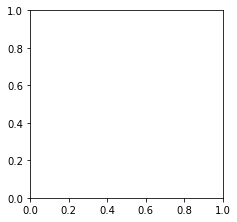

In [13]:
for pat in range(10):
    plt.figure(figsize=(20,20))
    print(da[1][pat])
    for n in range(11):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(da[0][n][pat][:,:,0],cmap="gray")

UAB300-RF


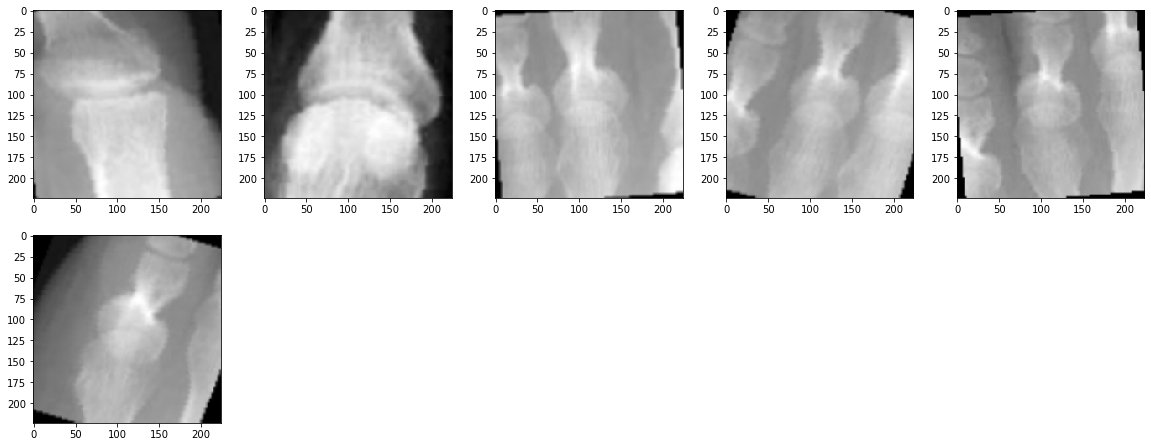

In [25]:
for pat in range(100):
    da = next(a)
    if da[1] == "UAB300-RF":
        plt.figure(figsize=(20,20))

        print(da[1])
        for n in range(6):
            ax = plt.subplot(5,5,n+1)
            plt.imshow(da[0][n][:,:,0],cmap="gray")

In [5]:
from dataset.overall_joints_dataset import hands_overall_joints_dataset,feet_overall_joints_dataset
from dataset.joints.joint_extractor import default_joint_extractor
from dataset.joints.joint_extractor_factory import get_joint_extractor
feet_extractor = get_joint_extractor("F", True)
ds, val_ds, no_val_samples = feet_overall_joints_dataset(configuration, 'train', joint_extractor = feet_extractor).create_feet_overall_joints_dataset_with_validation("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")

2020-04-10 20:01:00,399;WARNING - Missing permissions to create directory for caching!
2020-04-10 20:01:01,966;WARNING - Missing permissions to create directory for caching!


In [8]:
for a,b in ds.take(1):
#     plt.figure(figsize=(20,20))
    for n in range(6):
#         ax = plt.subplot(5,5,n+1)
#         plt.imshow(np.array(a[n][0])[:, :,0],cmap="gray")
        for i in range(16):
            print(np.array(a[n][i]).shape)

(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 224, 1)
(224, 

In [3]:
ds, val_ds, no_val_samples = hands_overall_joints_dataset(configuration, 'train', joint_extractor = default_joint_extractor()).create_hands_overall_joints_dataset_with_validation("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")

NameError: name 'hands_overall_joints_dataset' is not defined

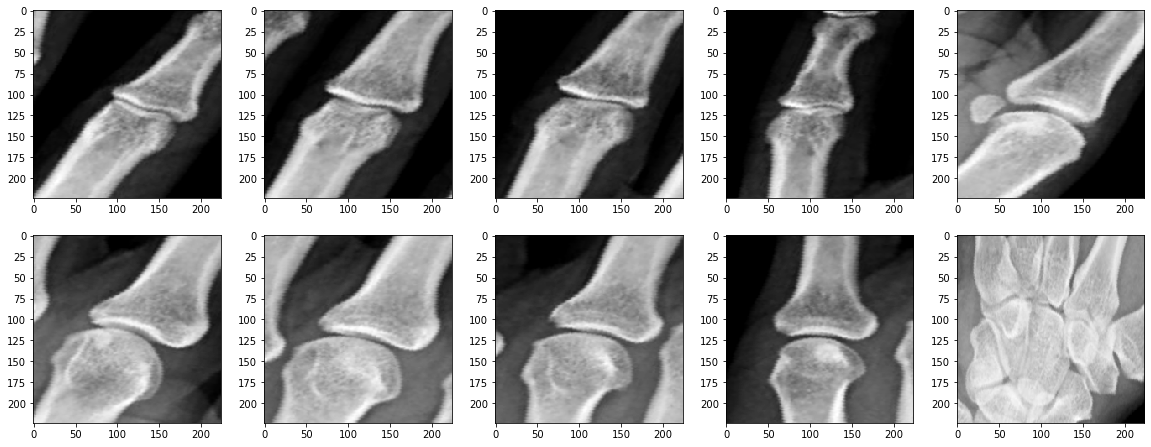

In [6]:
for a,b in ds.take(1):
    plt.figure(figsize=(20,20))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.array(a[n][0])[:, :,0],cmap="gray")

In [9]:
from model import combined_sc1_model
from train import combined_sc1_train

In [6]:
combined_model_feet = combined_sc1_model.get_feet_model("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/trained_models/v3/feet_narrowing_reg_old_pretrain_adam_shuffle.h5")
ds, val_ds, no_val_samples = feet_overall_joints_dataset(configuration, 'train', joint_extractor = default_joint_extractor()).create_feet_overall_joints_dataset_with_validation("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
combined_sc1_train.train_SC1_model(configuration,combined_model_feet,"SC1_v3A_feet_narrowing_dataset",ds,val_ds,epochs_before = 10, epochs_after = 51)


2020-03-31 12:01:52,987;WARNING - Missing permissions to create directory for caching!
2020-03-31 12:01:54,330;WARNING - Missing permissions to create directory for caching!
Train for 20 steps, validate for 5 steps
Epoch 1/10
2020-03-31 12:02:30,286;INFO - 2020-3-31_12.2.30
20/20 - 36s - loss: 13.6333 - mae: 2.4632 - val_loss: 33.1474 - val_mae: 4.6953
Epoch 2/10
2020-03-31 12:02:57,296;INFO - 2020-3-31_12.2.57
20/20 - 26s - loss: 6.5903 - mae: 1.9287 - val_loss: 17.1034 - val_mae: 2.3836
Epoch 3/10
2020-03-31 12:03:22,277;INFO - 2020-3-31_12.3.22
20/20 - 25s - loss: 7.9663 - mae: 1.9941 - val_loss: 22.3822 - val_mae: 3.4002
Epoch 4/10
2020-03-31 12:03:48,526;INFO - 2020-3-31_12.3.48
20/20 - 26s - loss: 6.6546 - mae: 1.8544 - val_loss: 14.9416 - val_mae: 2.3296
Epoch 5/10
2020-03-31 12:04:12,603;INFO - 2020-3-31_12.4.12
20/20 - 24s - loss: 5.5853 - mae: 1.7069 - val_loss: 15.9852 - val_mae: 2.1356
Epoch 6/10
2020-03-31 12:04:37,781;INFO - 2020-3-31_12.4.37
20/20 - 26s - loss: 6.0820 - 

In [14]:
combined_model_hands = combined_sc1_model.get_hand_model("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/trained_models/v3/hands_narrowing_reg_old_pretrain_adam_shuffle.h5",
                                                        "/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/trained_models/v3/wrists_narrowing_reg_old_pretrain_adam_shuffle.h5")
hand_extractor = get_joint_extractor("H", False)
ds, val_ds, no_val_samples = hands_overall_joints_dataset(configuration, 'train', joint_extractor = hand_extractor).create_hands_overall_joints_dataset_with_validation("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
combined_sc1_train.train_SC1_model(configuration,combined_model_hands,"SC1_v3A_hand_narrowing_dataset",ds,val_ds,epochs_before = 10, epochs_after = 51)


2020-04-10 20:29:26,765;WARNING - Missing permissions to create directory for caching!


AttributeError: in converted code:
    relative to /mnt/jw01-aruk-home01/projects/ra_challenge:

    RA_challenge/RA2_alpine_lads/ra_joint_predictions/dataset/overall_joints_dataset.py:265 __load_hand_joints  *
        joint_img = self._load_joint(img, joint_key, coords[coord_idx[0]:coord_idx[1]])
    RA_challenge/RA2_alpine_lads/ra_joint_predictions/dataset/overall_joints_dataset.py:218 _load_joint  *
        joint_img = js_ops._extract_joint_from_image(img, joint_key, coords[0], coords[1], self.joint_extractor)
    RA_challenge/RA2_alpine_lads/ra_joint_predictions/dataset/ops/joint_ops.py:50 _extract_joint_from_image  *
        box_height, box_width = joint_extractor(img_shape, joint_key)
    RA_challenge/RA2_alpine_lads/ra_joint_predictions/dataset/joints/joint_extractor.py:51 width_based_joint_extractor_fixed  *
        joint_scale = tf.cast(joint_scale_table.lookup(joint_key), img_shape.dtype)
    tensorflow2.0_gpu/lib/python3.7/site-packages/tensorflow_core/python/ops/lookup_ops.py:221 lookup
        if keys.dtype.base_dtype != self._key_dtype:

    AttributeError: 'str' object has no attribute 'dtype'
